# This is where the explicit similarity models are trained and evaluated

In [1]:
# https://apple.github.io/turicreate/docs/userguide/recommender/choosing-a-model.html
# https://apple.github.io/turicreate/docs/api/generated/turicreate.recommender.item_content_recommender.create.html#turicreate.recommender.item_content_recommender.create
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
# if you don't already have it
# !pip install turicreate

In [3]:
# data science libraries
import pandas as pd
import numpy as np
import turicreate as tc
from turicreate.toolkits.recommender.util import precision_recall_by_user
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

In [4]:
# loading and saving models
# because sometimes notebooks die
import pickle
from glob import glob
from os import path
from tqdm.notebook import tqdm

In [5]:
# data
raw_actions = tc.SFrame.read_csv('../data/raw_data/ratings.csv', verbose=False)
raw_tags = tc.SFrame.read_csv('../data/raw_data/tags.csv', verbose=False)
raw_books_with_tags = tc.SFrame.read_csv('../data/raw_data/book_tags.csv', verbose=False)
books = tc.SFrame.read_csv('../data/parsed_data/ultimate_books.csv', verbose=False)
to_read = tc.SFrame.read_csv('../data/raw_data/to_read.csv', verbose=False)
books_with_tags = tc.SFrame.read_csv('../data/parsed_data/books_with_tags.csv', verbose=False)
clustered_books_with_tags = tc.SFrame.read_csv('../data/parsed_data/clustered_books_with_tags.csv', verbose=False)
genre_tags = tc.SFrame.read_csv('../data/parsed_data/genre_tag_clusters.csv', verbose=False)
book_genre_clusters = tc.SFrame.read_csv('../data/parsed_data/books_with_genre_clusters.csv', verbose=False)

In [6]:
# remove actions from filtered books
actions = raw_actions.join(books)[['user_id','book_id','rating']]

In [7]:
# train and test data for explicit models
# Data needs to be held-back on a per-user basis so we don't
# have users we don't know anything about in the test data.
# The test data is restricted to highly rated items because
# we don't want precision to measure low rated books that
# the user read
high_rated_data = actions[actions["rating"] >= 4]
low_rated_data = actions[actions["rating"] < 4]
train_data_1, test_data = tc.recommender.util.random_split_by_user(
                                    high_rated_data, user_id='user_id', item_id='book_id')
train_data = train_data_1.append(low_rated_data)

In [10]:
# Count Vectorizer on tags
cv = CountVectorizer()
cv.fit(books_with_tags['tag_name'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [11]:
# Tags -> CountVectorizer -> TruncatedSVD -> 35 features
cv_svd = TruncatedSVD(n_components=35)
X = cv_svd.fit_transform(cv.transform(books_with_tags['tag_name']))
print(cv_svd.explained_variance_ratio_.sum())
svd_tags = tc.SFrame(pd.DataFrame(X))
svd_tags['book_id'] = books['book_id']

0.8065210650956977


In [12]:
# Tags -> tf-idf -> TruncatedSVD -> 35 features
tfid = TfidfVectorizer()
tfid.fit(books_with_tags['tag_name'])
tfid_svd = TruncatedSVD(n_components=35)
X = tfid_svd.fit_transform(tfid.transform(books_with_tags['tag_name']))
tfid_svd.explained_variance_ratio_.sum()
svd_tfid_tags = tc.SFrame(pd.DataFrame(X))
svd_tfid_tags['book_id'] = books['book_id']

0.5161981769429603


In [1]:
# combinations of side_data, model, latent factors, similarity types
side_data = [{'name': 'none', 'value': None}, 
              {'name': 'cluster_id', 'value':clustered_books_with_tags[['book_id','cluster']]},
              {'name': 'countVect->SVD', 'value':svd_tags},
              {'name': 'tfid->SVD', 'value':svd_tfid_tags},
              {'name': 'tag_clusters', 'value':book_genre_clusters}]

models = [{'name':'item_similarity', 'value': tc.recommender.item_similarity_recommender},
             {'name':'factorization', 'value': tc.recommender.factorization_recommender},
             {'name':'ranking_factorization', 'value': tc.recommender.ranking_factorization_recommender}]              
num_factors_options = [4, 8, 12]
similarity_types = ['jaccard','cosine','pearson']


NameError: name 'clustered_books_with_tags' is not defined

In [ ]:
trained_models = []
for model in models:
    for item_data in side_data:
        if model['name'] == 'content':
            # Content model must have item data
            if item_data['name'] != 'none':
                label = f"{model['name']} {item_data['name']}"
                print(label)
                test_model = model['value'].create(item_data['value'], 
                                          user_id='user_id', 
                                          item_id='book_id',
                                          observation_data=train_data,
                                          target='rating',
                                          verbose=False)
                
                trained_models.append({'name': label, 'model': test_model})
        
        elif model['name'] == 'factorization' or model['name'] == 'ranking_factorization':
            # ranking factorization doesn't converge when using tag clusters. Needs more memory
            # factorization has a latent factors param instead of a similarity type
            if model['name'] != 'ranking_factorization' and item_data['name'] != 'tag_clusters':
                for factors_option in num_factors_options:
                    label = f"{model['name']} {item_data['name']} {factors_option}"
                    print(label)
                    test_model = model['value'].create(train_data, 
                                          user_id='user_id', 
                                          item_id='book_id',
                                          target='rating',
                                          item_data=item_data['value'],
                                          num_factors=factors_option,
                                          verbose=False)
                    
                    trained_models.append({'name': label, 'model': test_model,})
        else:
            # item similarity has a similarity type instead of a latent factors param
            for similarity_type in similarity_types:
                label = f"{model['name']} {item_data['name']} {similarity_type}"
                print(label)
                test_model = model['value'].create(train_data, 
                                      user_id='user_id', 
                                      item_id='book_id',
                                      target='rating',
                                      item_data=item_data['value'],
                                      similarity_type=similarity_type,
                                      verbose=False)
                
                trained_models.append({'name': label,'model': test_model})

In [8]:
explicit_model_path = '../models/explicit_models'

In [20]:
# save models in case notebook crashes

def save_models(models, model_path):
    for e in models:
        file_name = e['name'].replace('-','').replace(' ','-')
        e['model'].save(path.join(model_path, file_name)


save_models(trained_models, explicit_model_path)
    

In [9]:
# load saved models, after notebook crashes
def load_model_dir(models_path, name_prefix=''):
    model_archives = glob(path.join(models_path,'*'))
    return [{'name': f'{name_prefix}{path.basename(model_path)}', 'model': tc.load_model(model_path)} for model_path in model_archives]

trained_models = load_model_dir(explicit_model_path)

In [10]:
# run evaluation metrics on each model using test data
def evaluate_models(models):
    for model_obj in tqdm(models):
        model_obj['eval'] = model_obj['model'].evaluate(test_data, exclude_known_for_precision_recall=True, verbose=False)
    return models

In [11]:
evaluated_models = evaluate_models(trained_models)

In [12]:
# Get precision and RMSE metrics from evaluated models

def make_precision_series(eval_array):
    x = [e['name'] for e in eval_array]
    y0 = [e['eval']['precision_recall_overall'][0]['precision'] for e in eval_array]
    y1 = [e['eval']['precision_recall_overall'][4]['precision'] for e in eval_array]
    y2 = [e['eval']['precision_recall_overall'][9]['precision'] for e in eval_array]
    return x, [y0,y1,y2]

def make_rmse_series(eval_array):
    x = [e['name'] for e in eval_array]
    y = [e['eval']['rmse_overall'] for e in eval_array]
    return x, y 



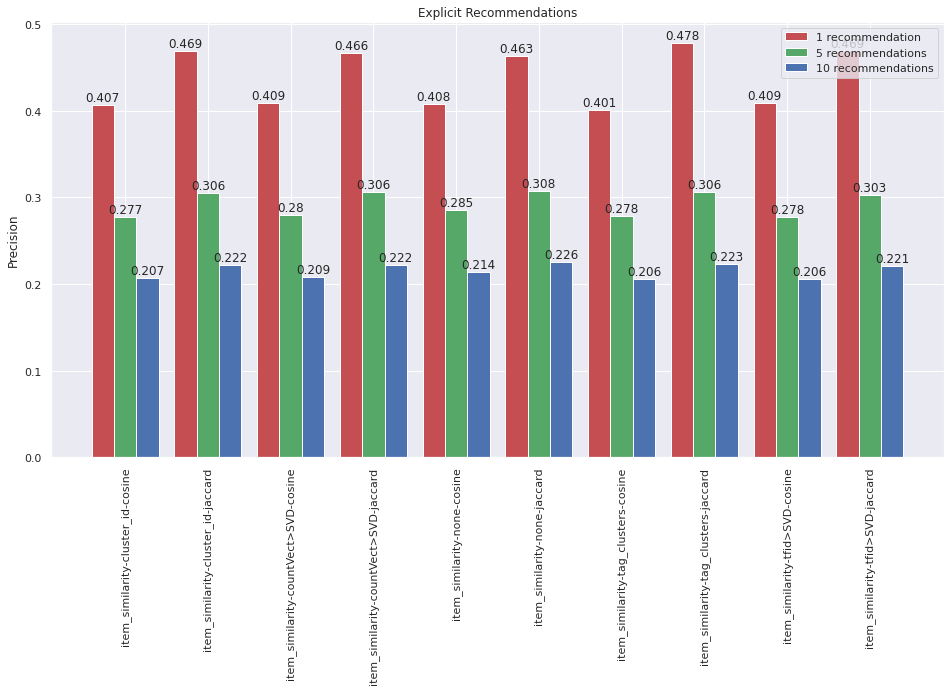

In [107]:
# Explicit Recommendations
explicit_evals  = [e for e in evaluated_models if 'factorization' not in e['name'] and 'content' not in e['name'] and 'pearson' not in e['name']]

x, ys = make_precision_series(sorted(explicit_evals, key=lambda x: x['name']))

ind = np.arange(len(ys[0]))  # the x locations for the groups
width = 0.27       # the width of the bars

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)

yvals = ys[0]
rects1 = ax.bar(ind, yvals, width, color='r')
zvals = ys[1]
rects2 = ax.bar(ind+width, zvals, width, color='g')
kvals = ys[2]
rects3 = ax.bar(ind+width*2, kvals, width, color='b')

ax.set_ylabel('Precision')
ax.set_xticks(ind+width)
ax.set_xticklabels( x , rotation='vertical')
ax.legend( (rects1[0], rects2[0], rects3[0]), ('1 recommendation', '5 recommendations', '10 recommendations') )

def autolabel(rects, yvals):
    for rect_index, rect in enumerate(rects):
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., h+0.001, round(yvals[rect_index],3),
                ha='center', va='bottom')

autolabel(rects1, ys[0])
autolabel(rects2, ys[1])
autolabel(rects3, ys[2])

plt.title('Explicit Recommendations')

plt.show()

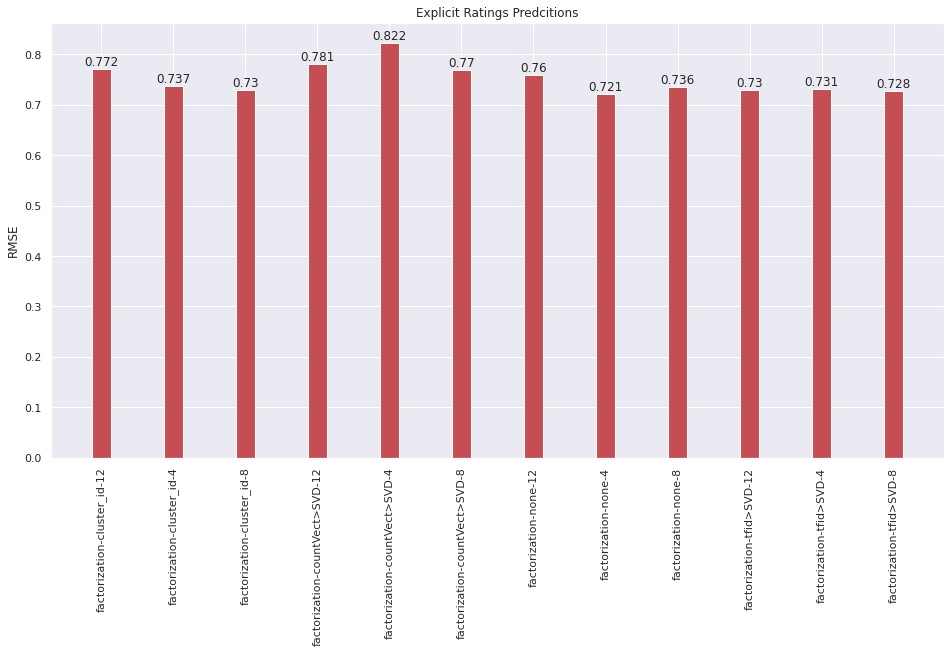

In [13]:
# Explicit Rating Predection
explicit_evals  = [e for e in evaluated_models if 'factorization' in e['name'] and 'content' not in e['name']]

x, y = make_rmse_series(sorted(explicit_evals, key=lambda x: x['name']))

ind = np.arange(len(y))  # the x locations for the groups
width = 0.27       # the width of the bars

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)

yvals = y
rects1 = ax.bar(ind+width, yvals, width, color='r')

ax.set_ylabel('RMSE')
ax.set_xticks(ind+width)
ax.set_xticklabels( x , rotation='vertical')
#ax.legend( (rects1[0], rects2[0], rects3[0]), ('1 recommendation', '5 recommendations', '10 recommendations') )

def autolabel(rects, yvals):
    for rect_index, rect in enumerate(rects):
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., h+0.001, round(yvals[rect_index],3),
                ha='center', va='bottom')

autolabel(rects1, y)

plt.title('Explicit Ratings Predcitions')

plt.show()

In [ ]:
# ind = np.arange(len(x))  # the x locations for the groups
# width = 0.27       # the width of the bars

# fig = plt.figure(figsize=(16,8))
# ax = fig.add_subplot(111)

# ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

# rvals = y
# rects0 = ax.bar(ind, rvals, width, color='r')
# yvals = ys[0]
# rects1 = ax2.bar(ind, yvals, width, color='c')
# zvals = ys[1]
# rects2 = ax2.bar(ind+width, zvals, width, color='g')
# kvals = ys[2]
# rects3 = ax2.bar(ind+width*2, kvals, width, color='b')

# ax.set_ylabel('Scores')
# ax.set_xticks(ind+width)
# ax.set_xticklabels( x , rotation='vertical')
# ax.legend( (rects0[0], rects1[0], rects2[0], rects3[0]), ('RMSE', '1 recommendation', '5 recommendations', '10 recommendations') )

# def autolabel(rects, yvals):
#     for rect_index, rect in enumerate(rects):
#         h = rect.get_height()
#         ax.text(rect.get_x()+rect.get_width()/2., h+0.001, round(yvals[rect_index],3),
#                 ha='center', va='bottom')

# autolabel(rects0, rvals)
# autolabel(rects1, yvals)
# autolabel(rects2, zvals)
# autolabel(rects3, kvals)

# plt.show()

In [10]:
test_data

NameError: name 'test_data' is not defined

In [22]:
trained_models['model'].reccomend()

TypeError: list indices must be integers or slices, not str

In [23]:
test_data

user_id,book_id,rating
70,5792,4
70,1206,4
70,8704,4
70,154,4
70,353,4
70,839,4
70,270,4
70,1580,4
70,1167,5
83,24,4


In [96]:
(train1[0:7]+test1_miss[0:1]+test1_hit[0:1]).sort('id')

user_id,book_id,rating,id
7416,8763,4,0
7416,7159,5,1
7416,4121,5,2
7416,4084,4,3
7416,4308,5,4
7416,4065,4,5
7416,9892,4,6
7416,1930,4,67
7416,6763,5,75


In [119]:
train1 = train_data[train_data['user_id'] == 7416]
test1 = test_data[test_data['user_id'] == 7416]
train1['S'] = 'TRAIN'
test1['S'] = 'TEST'

rec1 = trained_models[8]['model'].recommend([7416]).join(books)[['book_id','score','title']]
test1_hit = test1[test1['book_id'].is_in(rec1['book_id'])]
test1_miss = test1[test1['book_id'].is_in(rec1.join(test1)['book_id']) == False]
#test1_hit = range(len(train1), len(train1)+len(test1_hit))
#test1_miss = range(len(train1)+len(test1_hit), len(train1)+len(test1_hit)+len(test1_miss))

(train1[0:7]+test1_miss[0:1]+test1_hit[0:1]+test1_miss[1:2]+test1_hit[1:3]+test1_miss[2:4]).join(books)[['S','book_id','rating','title']].sort(['book_id']).sort(['S'], ascending=False).print_rows(num_rows=15)


+-------+---------+--------+--------------------------------+
|   S   | book_id | rating |             title              |
+-------+---------+--------+--------------------------------+
| TRAIN |   4065  |   4    | Black Rose (In the Garden, #2) |
| TRAIN |   4084  |   4    | Heaven and Earth (Three Si...  |
| TRAIN |   4121  |   5    | Face the Fire (Three Siste...  |
| TRAIN |   4308  |   5    |  Red Lily (In the Garden, #3)  |
| TRAIN |   7159  |   5    | This Heart of Mine (Chicag...  |
| TRAIN |   8763  |   4    |      Full Tilt (Full #2)       |
| TRAIN |   9892  |   4    | Salvation in Death (In Dea...  |
|  TEST |   1680  |   4    | Blue Dahlia (In the Garden...  |
|  TEST |   1930  |   4    | Dance Upon the Air (Three ...  |
|  TEST |   4926  |   5    | Secrets of a Summer Night ...  |
|  TEST |   5171  |   5    | Portrait in Death (In Deat...  |
|  TEST |   6763  |   5    | Innocent in Death (In Deat...  |
|  TEST |   7633  |   5    | Born in Death (In Death, #23)  |
|  TEST 

In [108]:
test1_hit

user_id,book_id,rating,id
7416,6763,5,75
7416,7633,5,78
7416,5171,5,79
7416,7976,5,80
7416,6762,4,81
7416,7041,5,82
7416,5512,5,83


In [107]:
rec1

book_id,score,title
4959,0.1270921310382103,"Promises in Death (InDeath, #28) ..."
5171,0.15966947665855066,"Portrait in Death (InDeath, #16) ..."
5512,0.18017265956793257,"Holiday in Death (InDeath, #7) ..."
6762,0.1831566824841855,"Judgment in Death (InDeath, #11) ..."
6763,0.1759636081866364,"Innocent in Death (InDeath, #24) ..."
7041,0.1804640293121338,"Loyalty in Death (InDeath, #9) ..."
7633,0.174967271178516,"Born in Death (In Death,#23) ..."
7976,0.17495313687111014,"Reunion in Death (InDeath, #14) ..."
9676,0.14970049929262988,"Fantasy in Death (InDeath, #30) ..."
9747,0.15142068311349668,"Kindred in Death (InDeath, #29) ..."


In [87]:
train1[0:7].join(books)

Columns:
	user_id	int
	book_id	int
	rating	int
	goodreads_book_id	int
	books_count	int
	authors	str
	original_publication_year	float
	original_title	str
	title	str
	language_code	str
	average_rating	float
	ratings_count	int
	work_ratings_count	int
	work_text_reviews_count	int
	ratings_1	int
	ratings_2	int
	ratings_3	int
	ratings_4	int
	ratings_5	int
	image_url	str
	small_image_url	str
	tag_name	str
	class_features	str
	cluster	int
	normalized	str

Rows: 7

Data:
+---------+---------+--------+-------------------+-------------+
| user_id | book_id | rating | goodreads_book_id | books_count |
+---------+---------+--------+-------------------+-------------+
|   7416  |   4065  |   4    |       86321       |      67     |
|   7416  |   4084  |   4    |       59830       |      75     |
|   7416  |   4121  |   5    |       59822       |      73     |
|   7416  |   4308  |   5    |       59821       |      66     |
|   7416  |   7159  |   5    |       73100       |      46     |
|   7416  |   8763  |   4    |       40313       |      21     |
|   7416  |   9892  |   4    |      2494204      |      45     |
+---------+---------+--------+-------------------+-------------+
+-------------------------------+---------------------------+
|            authors            | original_publication_year |
+-------------------------------+---------------------------+
|          Nora Roberts         |           2005.0          |
|          Nora Roberts         |           2001.0          |
|          Nora Roberts         |           2002.0          |
|          Nora Roberts         |           2005.0          |
|    Susan Elizabeth Phillips   |           2000.0          |
| Janet Evanovich, Charlotte... |           2002.0          |
|           J.D. Robb           |           2008.0          |
+-------------------------------+---------------------------+
+-------------------------------+--------------------------------+---------------+
|         original_title        |             title              | language_code |
+-------------------------------+--------------------------------+---------------+
|           Black Rose          | Black Rose (In the Garden, #2) |      eng      |
| Heaven and Earth (Three Si... | Heaven and Earth (Three Si...  |      eng      |
| Face the Fire (Three Siste... | Face the Fire (Three Siste...  |      eng      |
|            Red Lily           |  Red Lily (In the Garden, #3)  |     en-US     |
|       This Heart of Mine      | This Heart of Mine (Chicag...  |      eng      |
|           Full Tilt           |      Full Tilt (Full #2)       |     en-US     |
|       Salvation in Death      | Salvation in Death (In Dea...  |      eng      |
+-------------------------------+--------------------------------+---------------+
+----------------+---------------+--------------------+-------------------------+
| average_rating | ratings_count | work_ratings_count | work_text_reviews_count |
+----------------+---------------+--------------------+-------------------------+
|      4.03      |     29058     |       31458        |           728           |
|      4.13      |     28103     |       31458        |           788           |
|      4.15      |     27206     |       30556        |           691           |
|      4.07      |     29200     |       30746        |           747           |
|      4.12      |     21976     |       23916        |           969           |
|      3.7       |     14923     |       15433        |           319           |
|      4.26      |     14153     |       16574        |           649           |
+----------------+---------------+--------------------+-------------------------+
+-----------+-----------+-----------+-----------+-----------+
| ratings_1 | ratings_2 | ratings_3 | ratings_4 | ratings_5 |
+-----------+-----------+-----------+-----------+-----------+
|    180    |    1229   |    7135   |   11681   |   11233   |
|    142    |    922    |    6184   |   11519   |   12691   |
|    169   

In [83]:
train1[0:7].join(books)

Columns:
	user_id	int
	book_id	int
	rating	int
	id	int
	goodreads_book_id	int
	books_count	int
	authors	str
	original_publication_year	float
	original_title	str
	title	str
	language_code	str
	average_rating	float
	ratings_count	int
	work_ratings_count	int
	work_text_reviews_count	int
	ratings_1	int
	ratings_2	int
	ratings_3	int
	ratings_4	int
	ratings_5	int
	image_url	str
	small_image_url	str
	tag_name	str
	class_features	str
	cluster	int
	normalized	str

Rows: 7

Data:
+---------+---------+--------+----+-------------------+-------------+
| user_id | book_id | rating | id | goodreads_book_id | books_count |
+---------+---------+--------+----+-------------------+-------------+
|   7416  |   4065  |   4    | 5  |       86321       |      67     |
|   7416  |   4084  |   4    | 3  |       59830       |      75     |
|   7416  |   4121  |   5    | 2  |       59822       |      73     |
|   7416  |   4308  |   5    | 4  |       59821       |      66     |
|   7416  |   7159  |   5    | 1  |       73100       |      46     |
|   7416  |   8763  |   4    | 0  |       40313       |      21     |
|   7416  |   9892  |   4    | 6  |      2494204      |      45     |
+---------+---------+--------+----+-------------------+-------------+
+-------------------------------+---------------------------+
|            authors            | original_publication_year |
+-------------------------------+---------------------------+
|          Nora Roberts         |           2005.0          |
|          Nora Roberts         |           2001.0          |
|          Nora Roberts         |           2002.0          |
|          Nora Roberts         |           2005.0          |
|    Susan Elizabeth Phillips   |           2000.0          |
| Janet Evanovich, Charlotte... |           2002.0          |
|           J.D. Robb           |           2008.0          |
+-------------------------------+---------------------------+
+-------------------------------+--------------------------------+---------------+
|         original_title        |             title              | language_code |
+-------------------------------+--------------------------------+---------------+
|           Black Rose          | Black Rose (In the Garden, #2) |      eng      |
| Heaven and Earth (Three Si... | Heaven and Earth (Three Si...  |      eng      |
| Face the Fire (Three Siste... | Face the Fire (Three Siste...  |      eng      |
|            Red Lily           |  Red Lily (In the Garden, #3)  |     en-US     |
|       This Heart of Mine      | This Heart of Mine (Chicag...  |      eng      |
|           Full Tilt           |      Full Tilt (Full #2)       |     en-US     |
|       Salvation in Death      | Salvation in Death (In Dea...  |      eng      |
+-------------------------------+--------------------------------+---------------+
+----------------+---------------+--------------------+-------------------------+
| average_rating | ratings_count | work_ratings_count | work_text_reviews_count |
+----------------+---------------+--------------------+-------------------------+
|      4.03      |     29058     |       31458        |           728           |
|      4.13      |     28103     |       31458        |           788           |
|      4.15      |     27206     |       30556        |           691           |
|      4.07      |     29200     |       30746        |           747           |
|      4.12      |     21976     |       23916        |           969           |
|      3.7       |     14923     |       15433        |           319           |
|      4.26      |     14153     |       16574        |           649           |
+----------------+---------------+--------------------+-------------------------+
+-----------+-----------+-----------+-----------+-----------+-----+
| ratings_1 | ratings_2 | ratings_3 | ratings_4 | ratings_5 | ... |
+-----------+-----------+-----------+-----------+-----------+-----+
|    180    |    1229   |    7135   |   11681   |   11

In [75]:
train1[0:7].join(books)[['book_id','rating','title']]

book_id,rating,title
4065,4,"Black Rose (In theGarden, #2) ..."
4084,4,"Heaven and Earth (ThreeSisters Island, #2) ..."
4121,5,"Face the Fire (ThreeSisters Island, #3) ..."
4308,5,"Red Lily (In the Garden,#3) ..."
7159,5,"This Heart of Mine(Chicago Stars, #5) ..."
8763,4,Full Tilt (Full #2)
9892,4,"Salvation in Death (InDeath, #27) ..."


In [47]:
recs = trained_models[8]['model'].recommend([7416]).join(books)[['book_id','score','title']]

In [104]:
recs.print_rows(num)

book_id,score,title
4959,0.1270921310382103,"Promises in Death (InDeath, #28) ..."
5171,0.15966947665855066,"Portrait in Death (InDeath, #16) ..."
5512,0.18017265956793257,"Holiday in Death (InDeath, #7) ..."
6762,0.1831566824841855,"Judgment in Death (InDeath, #11) ..."
6763,0.1759636081866364,"Innocent in Death (InDeath, #24) ..."
7041,0.1804640293121338,"Loyalty in Death (InDeath, #9) ..."
7633,0.174967271178516,"Born in Death (In Death,#23) ..."
7976,0.17495313687111014,"Reunion in Death (InDeath, #14) ..."
9676,0.14970049929262988,"Fantasy in Death (InDeath, #30) ..."
9747,0.15142068311349668,"Kindred in Death (InDeath, #29) ..."


In [64]:
test1[test1['book_id'].is_in(rec1.join(test1)['book_id']) == False]

user_id,book_id,rating
7416,1930,4
7416,1680,4
7416,4926,5
7416,8236,4
7416,2901,4
7416,6020,5
7416,5044,4
7416,624,5
7416,5862,5
7416,9368,5


In [53]:
test1

user_id,book_id,rating
7416,1930,4
7416,1680,4
7416,4926,5
7416,8236,4
7416,2901,4
7416,6020,5
7416,5044,4


In [54]:
rec1

book_id,score,title
4959,0.1270921310382103,"Promises in Death (InDeath, #28) ..."
5171,0.15966947665855066,"Portrait in Death (InDeath, #16) ..."
5512,0.18017265956793257,"Holiday in Death (InDeath, #7) ..."
6762,0.1831566824841855,"Judgment in Death (InDeath, #11) ..."
6763,0.1759636081866364,"Innocent in Death (InDeath, #24) ..."
7041,0.1804640293121338,"Loyalty in Death (InDeath, #9) ..."
7633,0.174967271178516,"Born in Death (In Death,#23) ..."
7976,0.17495313687111014,"Reunion in Death (InDeath, #14) ..."
9676,0.14970049929262988,"Fantasy in Death (InDeath, #30) ..."
9747,0.15142068311349668,"Kindred in Death (InDeath, #29) ..."


In [32]:
test_data[test_data['user_id'] == 7416]

19

In [39]:
list(enumerate([f['name'] for f in trained_models]))

[(0, 'item_similarity-countVect>SVD-cosine'),
 (1, 'factorization-none-4'),
 (2, 'item_similarity-none-pearson'),
 (3, 'item_similarity-tfid>SVD-cosine'),
 (4, 'factorization-tfid>SVD-8'),
 (5, 'item_similarity-cluster_id-jaccard'),
 (6, 'factorization-cluster_id-8'),
 (7, 'factorization-none-12'),
 (8, 'item_similarity-tag_clusters-jaccard'),
 (9, 'content-cluster_id'),
 (10, 'item_similarity-tfid>SVD-jaccard'),
 (11, 'content-tag_clusters'),
 (12, 'item_similarity-tag_clusters-pearson'),
 (13, 'factorization-countVect>SVD-4'),
 (14, 'factorization-countVect>SVD-12'),
 (15, 'item_similarity-tfid>SVD-pearson'),
 (16, 'item_similarity-none-jaccard'),
 (17, 'item_similarity-cluster_id-pearson'),
 (18, 'factorization-cluster_id-4'),
 (19, 'content-countVect>SVD'),
 (20, 'item_similarity-tag_clusters-cosine'),
 (21, 'factorization-tfid>SVD-4'),
 (22, 'factorization-none-8'),
 (23, 'factorization-cluster_id-12'),
 (24, 'item_similarity-countVect>SVD-jaccard'),
 (25, 'factorization-countVect

In [42]:
trained_models[8]['model'].recommend([7416])

user_id,book_id,score,rank
7416,6762,0.1831566824841855,1
7416,7041,0.1804640293121338,2
7416,5512,0.18017265956793257,3
7416,6763,0.1759636081866364,4
7416,7633,0.174967271178516,5
7416,7976,0.17495313687111014,6
7416,5171,0.15966947665855066,7
7416,9747,0.15142068311349668,8
7416,9676,0.14970049929262988,9
7416,4959,0.1270921310382103,10
